<a href="https://colab.research.google.com/github/BlackJack2021/Zenn_DSWebAppHandsOn/blob/main/SourceCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 必要なパッケージのインストール・インポート

In [ ]:
# インストール
!pip install statsmodels
!pip install japanize-matplotlib

# インポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import requests
import io
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
from datetime import datetime
from dateutil.relativedelta import relativedelta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 25.0 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=e57df04c04cac4f33910fb6d03ec83993ab30565b8e29b32ce09ffa5bb748eab
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# データの取得及び前処理

In [ ]:
url = 'https://www3.nhk.or.jp/n-data/opendata/coronavirus/nhk_news_covid19_domestic_daily_data.csv'
r = requests.get(url)
df_raw = pd.read_csv(io.BytesIO(r.content))
df_raw

,日付,国内の感染者数_1日ごとの発表数,国内の感染者数_累計,国内の死者数_1日ごとの発表数,国内の死者数_累計
0,2020/1/16,1,1,0,0
1,2020/1/17,0,1,0,0
2,2020/1/18,0,1,0,0
3,2020/1/19,0,1,0,0
4,2020/1/20,0,1,0,0
...,...,...,...,...,...
902,2022/7/6,45818,9502468,12,31364
903,2022/7/7,47965,9550433,15,31379
904,2022/7/8,50099,9600532,29,31408
905,2022/7/9,55016,9655548,12,31420


In [ ]:
positive_df = df_raw[['日付', '国内の感染者数_1日ごとの発表数']]
positive_df.columns = ['date', 'number_of_positive']
# 日付を datetime 情報に変換し、 index に付加する
positive_df['date'] = pd.to_datetime(positive_df['date'], format="%Y/%m/%d")
positive_df.set_index('date', inplace=True, drop=False)
positive_df

,date,number_of_positive
date,,
2020-01-16,2020-01-16,1
2020-01-17,2020-01-17,0
2020-01-18,2020-01-18,0
2020-01-19,2020-01-19,0
2020-01-20,2020-01-20,0
...,...,...
2022-07-06,2022-07-06,45818
2022-07-07,2022-07-07,47965
2022-07-08,2022-07-08,50099


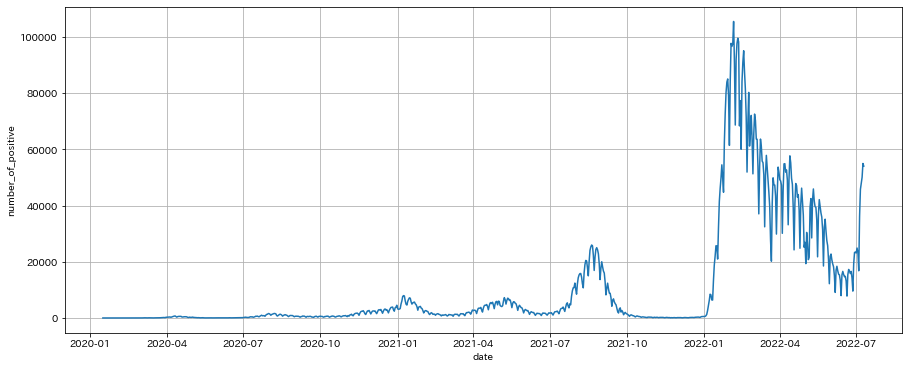

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(
    data = positive_df,
    x = 'date',
    y = 'number_of_positive',
    ax = ax
)
ax.grid()
plt.show()

## 可視化結果からの示唆
- 感染者数について等比級数的にデータが感染者数が増大したり減少したりしているように見える。
    - この観察は SIR モデルとも近しい（本当は非感染個体数を考えないといけないけれど...。）
    - $x_{t+1} = r x_{t}$ みたいな形でモデリングできないだろうか。
    - ただし $r$ は一定には見えないので、うまくこれが変動する時変係数のモデリングがしたい。
- $r_t$ の変動を考慮する際に、「トレンド」や「季節性」といった要素に分解しながら考えてみたい。

## 具体的な方向性の決定
- $r_t$ を状態空間モデルを用いてモデル化することをゴールとする。
- まず、前処理として $x_{t+1} = r_{t} x_{t}$ の両辺に log を取ると

$$
\begin{aligned}
&\log(x_{t+1}) = \log(r_{t}) + \log(x_{t}) \\
\Leftrightarrow \ &\log(x_{t+1}) - \log(x_{t}) = \log(r_{t})
\end{aligned}
$$

この時の $\log(\alpha_t)$ をモデリングすることにする。そのため、まずは対数差分を得ることから開始する。

- **なぜ対数を取るのか**
    - 後の季節性をモデリングする際に、「積がゼロ」となる制約が必要になる。この時に $\log(\cdot)$ の和がゼロとなる制約を置くことによりその制約を再現するため。
    - 対数差分は近似的に「その対象（ここではコロナ感染者数）の変化率」を表すことを意味する。そのため、$r_t$ をモデリングすることは近似的に「コロナ感染者数」をモデリングすることにつながるため。

In [ ]:
positive_df2 = positive_df.copy()
# まず感染者数について対数値をとる。
positive_df2['logged'] = positive_df2['number_of_positive'].apply(lambda x: np.log(x))

# inf を np.nan に置き換え（状態空間モデルでは欠損値を補完することなくモデリングが可能）
positive_df2['logged'] = positive_df2['logged'].replace((-np.inf, np.inf), np.nan)

# 対数差分を取る
positive_df2['y'] = positive_df2['logged'].diff()

# 直後に曜日のデータを用いるため曜日を割り出しておく
positive_df2['day_name'] = positive_df['date'].dt.day_name()

# 最初は人数が少なすぎて対数や対数差分をとる演算が不適切なので、2年前までのデータを対象とする
two_years_ago = datetime.today() - relativedelta(years=2)
positive_df2 = positive_df2.loc[positive_df2.index>=two_years_ago]
positive_df2

,date,number_of_positive,logged,y,day_name
date,,,,,
2020-07-12,2020-07-12,407,6.008813,0.052976,Sunday
2020-07-13,2020-07-13,259,5.556828,-0.451985,Monday
2020-07-14,2020-07-14,333,5.808142,0.251314,Tuesday
2020-07-15,2020-07-15,450,6.109248,0.301105,Wednesday
2020-07-16,2020-07-16,624,6.436150,0.326903,Thursday
...,...,...,...,...,...
2022-07-06,2022-07-06,45818,10.732432,0.235949,Wednesday
2022-07-07,2022-07-07,47965,10.778227,0.045795,Thursday
2022-07-08,2022-07-08,50099,10.821756,0.043529,Friday


## 対数差分の可視化
### 時系列プロット

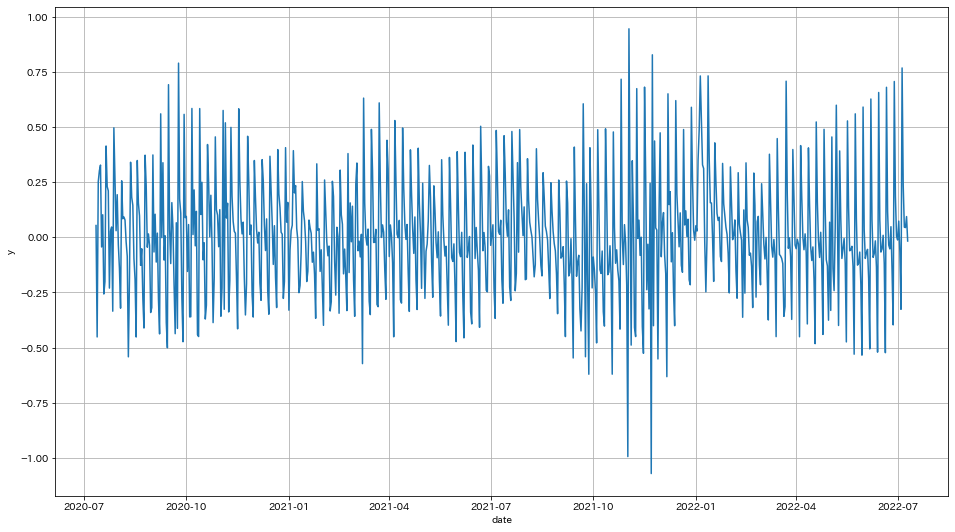

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(
    data = positive_df2,
    x = 'date',
    y = 'y',
    ax = ax
)
ax.grid()
fig.show()

#### 可視化の結果から分かること
- 全体的には右肩上がり、右肩下がりといった傾向は確認されない
- 一方局所的に右肩上がりのトレンドだったり右肩下がりのトレンドだったりする。

### 曜日ごとのプロット

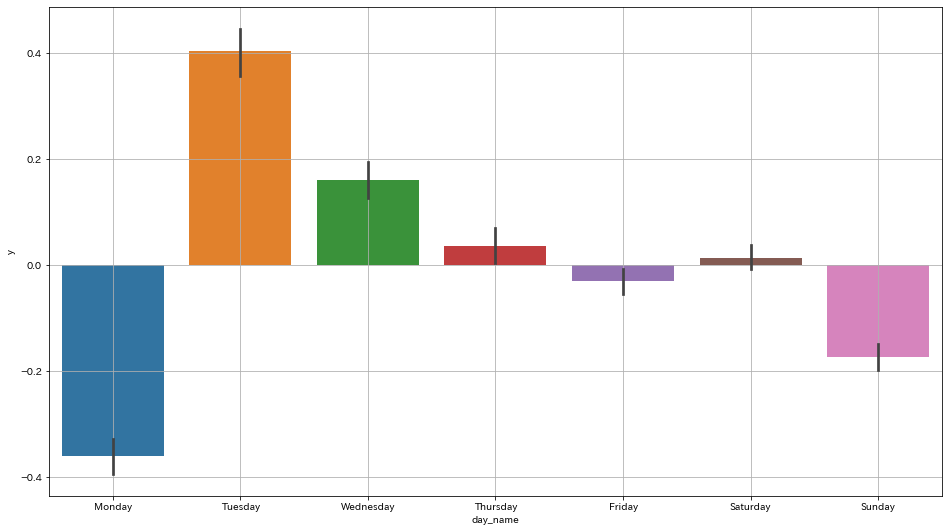

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sns.barplot(
    data = positive_df2,
    x = 'day_name',
    y = 'y',
    ax = ax,
    order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
ax.grid()
fig.show()

#### 可視化の結果から分かること
- 曜日ごとに割と増加のトレンドが異なる
- 週次の周期性はトレンドに含めてもいいかも。

# 状態空間モデルを用いたモデリング
## **ローカルレベルモデルの構築**
- まずはシンプルなモデル(**ローカルレベルモデル**)を構築する。

$$
\begin{aligned}
y_t &= \mu_t + u_{y,t}\\
\mu_{t} &= \mu_{t-1}+ u_{\mu,t}
\end{aligned}
$$

- $\mu_t$ : トレンドを表す。個のトレンドは2式目で示すように時変的である。

- カスタム時の各種変数の定義は基本的にこちらに書いてある通り。
    - 引用元は[公式ドキュメント](https://www.statsmodels.org/stable/statespace.html) です。

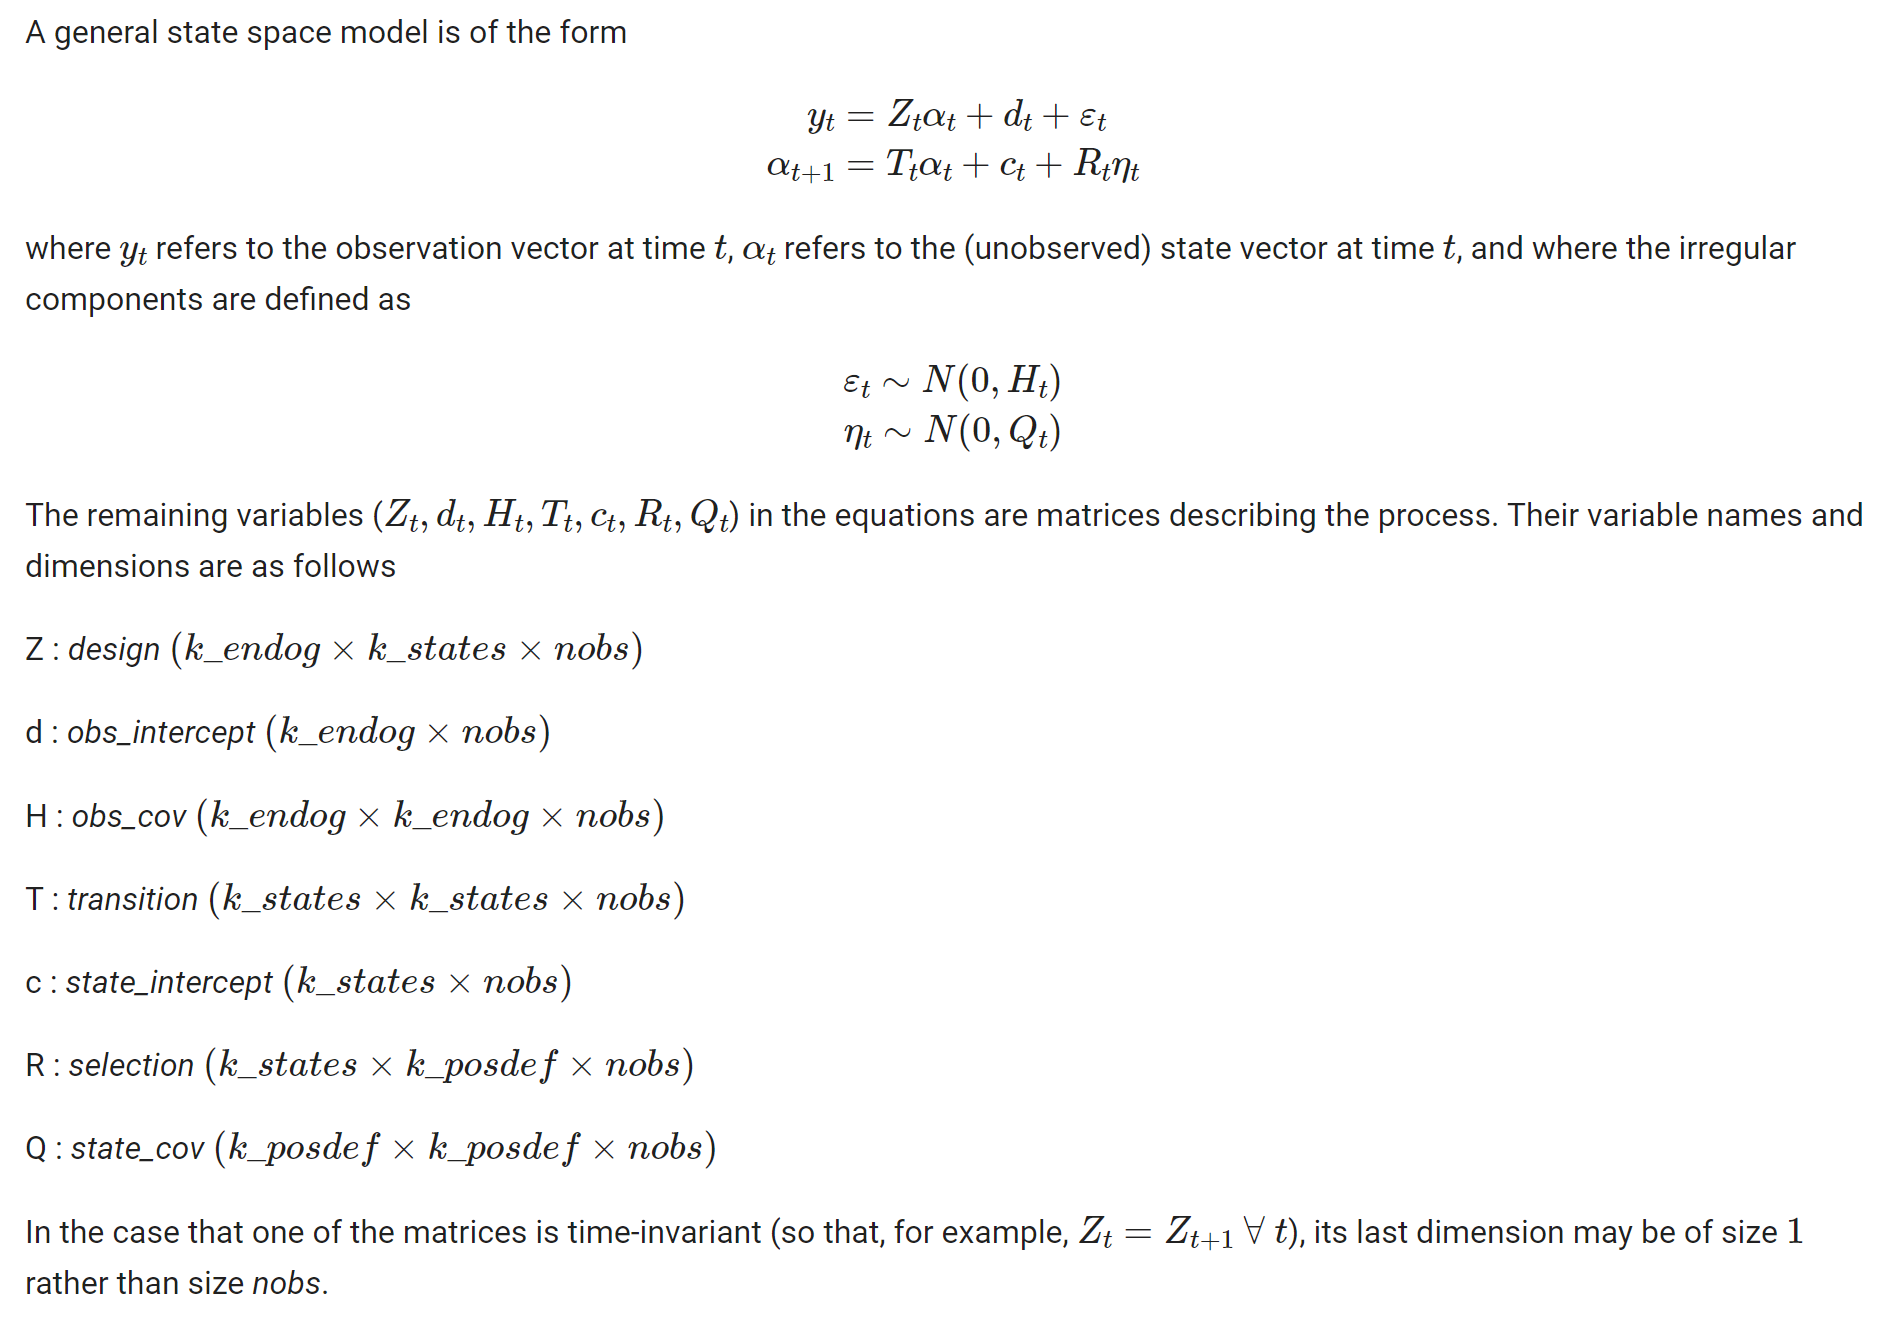

In [ ]:
class LocalLevelModel(sm.tsa.statespace.MLEModel):
    
    # クラス変数として各種名称, 非負であるもの、推定の初期値を宣言。
    param_names = ['観測誤差','トレンド誤差']
    positive_parameter_index = [0, 1]
    start_params = [0.01, 0.01]

    def __init__(self, endog):
        
        # まず親クラスのインストラクタを起動する
        super(LocalLevelModel, self).__init__(
            endog = endog,
            k_states = 1, # state の数を指定する。今回は mu 一つだけ。
            freq = 'D', # date 単位のデータであることを指定する。
            initialization = 'diffuse' # 推定の際に散漫カルマンフィルタの利用を指示。
        )

        # ssm['design'] で状態と観測変数の関係性を定義する(次元は「観測変数の数」＊「状態変数の数」)
        # 今回は状態変数の値がそのまま観測変数への影響となるので、1*1行列の要素に1を代入すればよい。
        k_endog = 1
        self.ssm['design'] = np.zeros([k_endog, self.k_states])
        self.ssm['design',0,0] = 1

        # ssm['transition'] で状態の遷移のルールを記述（次元は「状態変数の数」*「状態変数の数」）
        # 今回は過去のトレンド変数（＋誤差）がそのまま今回のトレンドに受け継がれるので、1*1行列の要素に1を代入すればよい。
        self.ssm['transition'] = np.zeros([self.k_states, self.k_states])
        self.ssm['transition', 0, 0] = 1
        
        # ssm['selection'] で状態と状態誤差の関係性を定義（次元は「状態変数の数」*「状態誤差の数」）
        # 今回はそのままトレンド誤差をトレンドに反映させるので、1*1行列の要素に1を代入すればよい。
        k_posdef = 1 # 状態誤差の数
        self.ssm['selection'] = np.zeros([self.k_states, k_posdef])
        self.ssm['selection', 0, 0] = 1



    def transform_params(self, unconstrained):
        '''
        正の値が指定されたパラメータについて二乗値をとります。
        この操作により、値が二乗されますが仮にマイナスの値が入っていたとしてもプラスの値になります。
        二乗されてしまった分については直後の untransform_params にて平方根に変換します。
        '''
        constrained = unconstrained.copy()
        constrained[self.positive_parameter_index] = (
            constrained[self.positive_parameter_index] ** 2
        )
        return constrained

    def untransform_params(self, constrained):
        '''２乗した値を正の値の平方根に直します。'''
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameter_index] = (
            unconstrained[self.positive_parameter_index] ** 0.5
        )

    def update(self, params, **kwargs):
        params = super(LocalLevelModel, self).update(params, **kwargs)
        # 0番目のパラメータ=観測誤差の更新値を観測誤差分散共分散行列に代入
        self.ssm['obs_cov', 0, 0] = params[0]
        # 1番目のパラメータ=トレンド誤差の更新値を状態誤差分散共分散行列に代入
        self.ssm['state_cov', 0, 0] = params[1]

In [ ]:
endog = 'y'
local_level_model = LocalLevelModel(endog=positive_df2[endog])
result_llm = local_level_model.fit()
print(result_llm.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  729
Model:                LocalLevelModel   Log Likelihood                -101.150
Date:                Mon, 11 Jul 2022   AIC                            208.301
Time:                        04:47:30   BIC                            222.076
Sample:                    07-12-2020   HQIC                           213.616
                         - 07-10-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
観測誤差           0.0764      0.004     21.360      0.000       0.069       0.083
トレンド誤差      2.388e-11   2.56e-06   9.35e-06      1.000   -5.01e-06    5.01e-06
Ljung-Box (Q):                     2239.46   Jarque-

In [ ]:
estimated_states = result_llm.smoothed_state
trend = estimated_states[0]

result_df = pd.DataFrame({
    '日付': positive_df2['date'],
    '観測値': positive_df2[endog],
    'トレンド': trend,
})
result_df_melted = result_df.melt(
    id_vars='日付',
    var_name='decomposition',
    value_name='感染者数対数差分'
).sort_values(by='日付')

fig = px.line(
    data_frame = result_df_melted,
    x = '日付',
    y = '感染者数対数差分',
    color = 'decomposition'
)
fig.show()

In [ ]:
endog = 'y'
unobserved_components_local_linear = sm.tsa.UnobservedComponents(
    endog = positive_df2[endog],
    level = 'local level',
    #seasonal = 7,
    #stochastic_seasonal=True
)
result_uoll = unobserved_components_local_linear.fit()
print(result_uoll.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  729
Model:                    local level   Log Likelihood                -100.231
Date:                Mon, 11 Jul 2022   AIC                            204.463
Time:                        04:47:31   BIC                            213.643
Sample:                    07-12-2020   HQIC                           208.005
                         - 07-10-2022                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0764      0.004     21.361      0.000       0.069       0.083
sigma2.level      1.883e-11   2.55e-06   7.37e-06      1.000   -5.01e-06    5.01e-06
Ljung-Box (Q):              

#### 観察されること
- ほとんどすべてを「説明できない部分」として説明。
- その結果トレンドとして推定されそうな部分も全く推定されなくなっている。

#### **ネクストアクション**
- 季節性を組み込んだローカルレベルモデルを構築したい。
    - そうすれば「説明できない部分」の影響を小さくできそうなので、きちんとトレンドを推定できるようになるかも。

## **季節性を追加したローカルレベルモデル**

- 観測値と状態の関係
$$
\begin{aligned}
y_t = \mu_t + \gamma_{1,t} + u_t
\end{aligned}
$$

- 状態遷移
$$
\begin{aligned}
\mu_t &= \mu_{t-1} + u_{\mu,t} \\
\gamma_{1,t} &= \sum_{i=1}^{6}\gamma_{i,t-1}+u_{\gamma,t} \\
\gamma_{2,t} &= \gamma_{1,t-1} \\
\gamma_{3,t} &= \gamma_{2,t-1} \\
\gamma_{4,t} &= \gamma_{3,t-1} \\
\gamma_{5,t} &= \gamma_{4,t-1} \\
\gamma_{6,t} &= \gamma_{5,t-1} \\
\end{aligned}
$$


In [ ]:
class LocalLevelSeasonalModel(sm.tsa.statespace.MLEModel):

    param_names = ['観測誤差', 'トレンド誤差', '季節誤差']
    positive_parameter_index = [0,1,2]
    start_params = [0.01, 0.01, 0.01]

    # 更新。今回は状態誤差として2つ攪乱項を用いているので2つであると指定。
    k_posdef = 2

    def __init__(self, endog):
        # 初期設定
        super(LocalLevelSeasonalModel, self).__init__(
            endog = endog,
            k_states = 7, # 今回は状態が7つ,
            k_posdef = self.k_posdef, # k_posdef は2重で指定しないとエラーになるので指定。
            freq='D',
            initialization = 'diffuse'
        )
        # design matrix (観測値と状態の関係性)の指定
        self.ssm['design'] = np.array(
            [[1, 1, 0, 0, 0, 0, 0]]
        )

        # transition matrix (現在状態と過去状態の関係性)の指定
        self.ssm['transition'] = np.array([
            [1, 0, 0, 0, 0, 0, 0],
            [0, -1, -1, -1, -1, -1, -1],
            [0, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 1, 0]
        ])

        # selection matrix (状態と状態誤差の関係性)の指定
        self.ssm['selection'] = np.zeros([self.k_states, self.k_posdef])
        self.ssm['selection',0,0] = 1
        self.ssm['selection',1,1] = 1

    
    def transform_params(self, unconstrained):
        '''指定したパラメータに関して正の値に入るように処理をします。'''
        constrained = unconstrained.copy()
        constrained[self.positive_parameter_index] = (
            constrained[self.positive_parameter_index] ** 2
        )
        return constrained

    def untransform_params(self, constrained):
        '''２乗した値を正の値の平方根に直します。'''
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameter_index] = (
            unconstrained[self.positive_parameter_index] ** 0.5
        )

    def update(self, params, **kwargs):
        params = super(LocalLevelSeasonalModel, self).update(params, **kwargs)
        self['obs_cov', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[1]
        self['state_cov', 1, 1] = params[2]

In [ ]:
endog = 'y'
local_level_seasonal_model = LocalLevelSeasonalModel(endog=positive_df2[endog])
result_llsm = local_level_seasonal_model.fit()
print(result_llsm.summary())

                              Statespace Model Results                             
Dep. Variable:                           y   No. Observations:                  729
Model:             LocalLevelSeasonalModel   Log Likelihood                 294.379
Date:                     Mon, 11 Jul 2022   AIC                           -568.758
Time:                             04:47:32   BIC                           -522.841
Sample:                         07-12-2020   HQIC                          -551.041
                              - 07-10-2022                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
観測誤差           0.0188      0.001     26.857      0.000       0.017       0.020
トレンド誤差      9.549e-05   3.05e-05      3.132      0.002    3.57e-05       0.000
季節誤差        

In [ ]:
estimated_states = result_llsm.smoothed_state
trend = estimated_states[0]
seasonal = estimated_states[1]

result_df = pd.DataFrame({
    '日付': positive_df2['date'],
    '観測値': positive_df2[endog],
    'トレンド': trend,
    '観測値＋トレンド': trend+seasonal
})
result_df_melted = result_df.melt(
    id_vars='日付',
    var_name='decomposition',
    value_name='対数差分'
).sort_values(by='日付')

fig = px.line(
    data_frame = result_df_melted,
    x = '日付',
    y = '対数差分',
    color = 'decomposition'
)
fig.show()
fig.write_html("modeling_result.html")

#### 観察されること
- 先ほどよりも大分ましな推定となった。
    - 週次の季節性をモデルに組み込むことでトレンドをうまく拾えるようになった。

In [ ]:
# 1か月先まで予測を行ってみる。steps で予測期間（ここでは日数）を指定する。
one_month_forecasts = result_llsm.get_forecast(steps=30)
# summary_frame メソッドにより点予測・予測信頼区間の情報を出力可能。alpha で信頼係数を指定（0.05 なら 95%信頼区間）。
summary_of_forecasts_df = one_month_forecasts.summary_frame(alpha=0.05)
summary_of_forecasts_df

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-07-11,-0.416947,0.158394,-0.727393,-0.106501
2022-07-12,0.667445,0.158399,0.356988,0.977901
2022-07-13,0.154008,0.158576,-0.156796,0.464811
2022-07-14,-0.003205,0.158789,-0.314425,0.308016
2022-07-15,0.004542,0.158993,-0.307078,0.316163
2022-07-16,0.074930,0.159139,-0.236978,0.386838
2022-07-17,-0.063144,0.159140,-0.375052,0.248765
2022-07-18,-0.416947,0.163958,-0.738300,-0.095594
2022-07-19,0.667445,0.163963,0.346082,0.988807
2022-07-20,0.154008,0.164135,-0.167690,0.475705


In [ ]:
summary_of_forecasts_df = summary_of_forecasts_df[['mean','mean_ci_lower','mean_ci_upper']]
summary_of_forecasts_df.columns = ['point_prediction', 'confidence_interval_low', 'confidence_interval_high']
result_df = pd.merge(summary_of_forecasts_df, positive_df2[endog], left_index=True, right_index=True, how='outer').reset_index()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x = result_df['index'],
    y = result_df[endog],
    name = '観測値'
))

fig.add_trace(go.Scatter(
    x=result_df['index'],
    y=result_df['confidence_interval_low'],
    line={'color':'yellow'},
    name='下側信頼区間95%'
))

fig.add_trace(go.Scatter(
    x=result_df['index'],
    y=result_df['confidence_interval_high'],
    line={'color':'yellow'},
    fill='tonexty',
    name='上側信頼区間95%'
))

fig.add_trace(go.Scatter(
    x=result_df['index'],
    y=result_df['point_prediction'],
    line={'color':'red'},
    name='点予測値'
))

fig.show()

# **外生変数の追加**

- 祝日の影響を含めて推定してみる。

In [ ]:
# 必要なパッケージのインストールおよびインポート
!pip install jpholiday
import jpholiday

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 祝日、祝日の翌日、祝日の翌々日を表すダミー変数を追加する。
positive_df3 = positive_df2.copy()
positive_df3['holiday'] = positive_df3['date'].apply(lambda x: jpholiday.is_holiday(x))
positive_df3['1day_after_holiday'] = False
positive_df3['2day_after_holiday'] = False
for i, (_, row) in enumerate(positive_df3.iterrows()):
    if row['holiday']:
        if i+1 <= positive_df3.shape[0]:
            positive_df3['1day_after_holiday'].iloc[i+1] = True
        else:
            continue        
        if i+2 <= positive_df3.shape[0]:
            positive_df3['2day_after_holiday'].iloc[i+2] = True

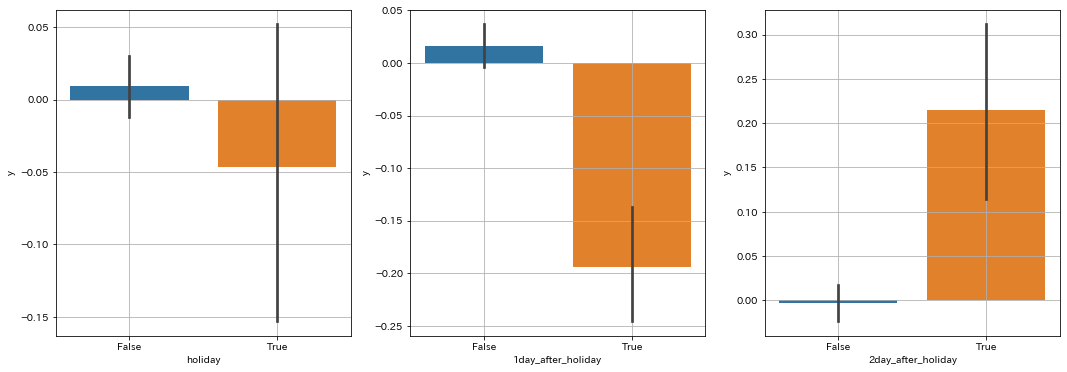

In [ ]:
# それぞれのダミー変数ごとに可視化を実行
fig, axes = plt.subplots(ncols=3,figsize=(18,6))
sns.barplot(
    data = positive_df3,
    x = 'holiday',
    y = 'y',
    ax = axes[0]
)
sns.barplot(
    data = positive_df3,
    x = '1day_after_holiday',
    y = 'y',
    ax = axes[1]
)
sns.barplot(
    data = positive_df3,
    x = '2day_after_holiday',
    y = 'y',
    ax = axes[2]
)
axes[0].grid()
axes[1].grid()
axes[2].grid()
fig.show()

#### **観察されること**
1. 祝日の翌日には感染者増加率が有意に減少する。
2. 祝日の翌々日には感染者増加率が有意に増加する。

#### **やりたいこと**
- モデルに「祝日の翌日ダミー」と「祝日の翌々日ダミー」を追加したい。
- 組み込み方は２つ存在する。
    - 推定係数が一定と考える（＝通常の回帰のように推定する）アプローチ
    - 推定係数が動的に動くと考える（＝状態変数として表現する）アプローチ

# **外生変数（固定係数）**

In [ ]:
class LocalLevelSeasonalExogenousFixedEstimatorModel(sm.tsa.statespace.MLEModel):

    param_names = ['観測誤差', 'トレンド誤差', '季節誤差', '祝日の翌日ダミー', '祝日の翌々日ダミー']
    positive_parameter_index = [0,1,2]
    start_params = [0.01, 0.01, 0.01, 0.01, 0.01]

    # 更新。今回は状態誤差として2つ攪乱項を用いているので2つであると指定。
    k_posdef = 2

    def __init__(self, endog, exog1: pd.Series, exog2: pd.Series):
        # 初期設定
        super(LocalLevelSeasonalExogenousFixedEstimatorModel, self).__init__(
            endog = endog,
            k_states = 7, 
            k_posdef = self.k_posdef, # k_posdef は2重で指定しないとエラーになるので指定。
            freq='D',
            initialization = 'diffuse'
        )
        # design matrix (観測値と状態の関係性)の指定
        self.ssm['design'] = np.array(
            [[1, 1, 0, 0, 0, 0, 0]]
        )

        # 外生変数の定義（NEW!!）
        self.exog1 = exog1.values.reshape(1,-1)
        self.exog2 = exog2.values.reshape(1,-1)
        # obs_intercept (観測値の切片)の指定(NEW!!)
        num_of_obs = len(endog)
        num_of_endog = 1
        self.ssm['obs_intercept'] = np.zeros([num_of_endog, num_of_obs])

        # transition matrix (現在状態と過去状態の関係性)の指定
        self.ssm['transition'] = np.array([
            [1, 0, 0, 0, 0, 0, 0],
            [0, -1, -1, -1, -1, -1, -1],
            [0, 1, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 1, 0]
        ])

        # selection matrix (状態と状態誤差の関係性)の指定
        self.ssm['selection'] = np.zeros([self.k_states, self.k_posdef])
        self.ssm['selection',0,0] = 1
        self.ssm['selection',1,1] = 1

    
    def transform_params(self, unconstrained):
        '''指定したパラメータに関して正の値に入るように処理をします。'''
        constrained = unconstrained.copy()
        constrained[self.positive_parameter_index] = (
            constrained[self.positive_parameter_index] ** 2
        )
        return constrained

    def untransform_params(self, constrained):
        '''２乗した値を正の値の平方根に直します。'''
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameter_index] = (
            unconstrained[self.positive_parameter_index] ** 0.5
        )

    def update(self, params, **kwargs):
        params = super(LocalLevelSeasonalExogenousFixedEstimatorModel, self).update(params, **kwargs)
        self['obs_cov', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[1]
        self['state_cov', 1, 1] = params[2]
        # d = beta_1 * x_1 + beta_2 * x_2 の式形をここで指定する。
        self['obs_intercept', 0, :] = params[3] * self.exog1 + params[4] * self.exog2 

In [ ]:
endog = 'y'
exog1 = '1day_after_holiday'
exog2 = '2day_after_holiday'
local_level_seasonal_exogenous_fixed_estimator_model = LocalLevelSeasonalExogenousFixedEstimatorModel(
    endog=positive_df3[endog],
    exog1=positive_df3[exog1],
    exog2=positive_df3[exog2]
)
result_llsefem = local_level_seasonal_exogenous_fixed_estimator_model.fit()
print(result_llsefem.summary())

                                         Statespace Model Results                                         
Dep. Variable:                                                  y   No. Observations:                  729
Model:             LocalLevelSeasonalExogenousFixedEstimatorModel   Log Likelihood                 473.130
Date:                                            Mon, 11 Jul 2022   AIC                           -922.260
Time:                                                    04:49:15   BIC                           -867.159
Sample:                                                07-12-2020   HQIC                          -901.000
                                                     - 07-10-2022                                         
Covariance Type:                                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

In [ ]:
estimated_states = result_llsefem.smoothed_state
trend = estimated_states[0]
seasonal = estimated_states[1]

# 推定された係数に、各日のダミー変数の値（0 or 1）をかけています。
holiday_after_effect1 = result_llsefem.params['祝日の翌日ダミー'] * positive_df3['1day_after_holiday']
holiday_after_effect2 = result_llsefem.params['祝日の翌々日ダミー'] * positive_df3['2day_after_holiday']

result_df = pd.DataFrame({
    '日付': positive_df3['date'],
    '観測値': positive_df3[endog],
    'トレンド': trend,
    '祝日の翌日': holiday_after_effect1,
    '祝日の翌々日': holiday_after_effect2,
    'トレンド+季節': trend+seasonal,
    'トレンド+祝日': trend + holiday_after_effect1 + holiday_after_effect2,
    'トレンド+季節+祝日': trend + holiday_after_effect1 + holiday_after_effect2 + seasonal,
})
result_df_melted = result_df.melt(
    id_vars='日付',
    var_name='decomposition',
    value_name='対数差分'
).sort_values(by='日付')

fig = px.line(
    data_frame = result_df_melted,
    x = '日付',
    y = '対数差分',
    color = 'decomposition'
)
fig.show()
fig.write_html("modeling_result.html")

# **外生変数(時変係数)**





In [ ]:
class LocalLevelSeasonalExogenousNonfixedEstimatorModel(sm.tsa.statespace.MLEModel):

    param_names = ['観測誤差', 'トレンド誤差', '季節誤差', '祝日の翌日誤差', '祝日の翌々日誤差']
    positive_parameter_index = [0,1,2,3,4]
    start_params = [0.01, 0.01, 0.01, 0.01, 0.01]

    # 更新。今回は状態誤差として2つ攪乱項を用いているので2つであると指定。
    k_posdef = 4

    def __init__(self, endog, exog1, exog2):
        # 初期設定
        super(LocalLevelSeasonalExogenousNonfixedEstimatorModel, self).__init__(
            endog = endog,
            k_states = 9, # 今回は状態が7つ,
            k_posdef = self.k_posdef, # k_posdef は2重で指定しないとエラーになるので指定。
            freq='D',
            initialization = 'diffuse'
        )
        # design matrix (観測値と状態の関係性)の指定
        num_of_endog = 1
        num_of_obs = len(endog)
        # 外生変数の宣言 NEW!!
        self.exog1 = exog1.values.reshape(1,-1)
        self.exog2 = exog2.values.reshape(1,-1)
        # design 行列の次元に観測データ数を加える NEW!!
        self.ssm['design'] = np.zeros([self.k_endog, self.k_states, num_of_obs])
        self.ssm['design',0,0,:] = 1 # トレンド
        # 外生変数の値を design 行列に格納する NEW!!
        self.ssm['design',0,1,:] = self.exog1 # 祝日の翌日
        self.ssm['design',0,2,:] = self.exog2 # 祝日の翌々日
        self.ssm['design',0,3,:] = 1 # 季節項

        # transition matrix (現在状態と過去状態の関係性)の指定
        self.ssm['transition'] = np.array([
            [1, 0, 0, 0, 0, 0, 0, 0, 0], # トレンド
            [0, 1, 0, 0, 0, 0, 0, 0, 0], # 祝日の翌日の影響
            [0, 0, 1, 0, 0, 0, 0, 0, 0], # 祝日の翌々日の影響
            [0, 0, 0, -1, -1, -1, -1, -1, -1], # 以下季節
            [0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1, 0]
        ])

        # selection matrix (状態と状態誤差の関係性)の指定
        self.ssm['selection'] = np.zeros([self.k_states, self.k_posdef])
        self.ssm['selection',0,0] = 1 # トレンド
        self.ssm['selection',1,1] = 1 # 祝日の翌日
        self.ssm['selection',2,2] = 1 # 祝日の翌々日
        self.ssm['selection',3,3] = 1 # 季節

    
    def transform_params(self, unconstrained):
        '''指定したパラメータに関して正の値に入るように処理をします。'''
        constrained = unconstrained.copy()
        constrained[self.positive_parameter_index] = (
            constrained[self.positive_parameter_index] ** 2
        )
        return constrained

    def untransform_params(self, constrained):
        '''２乗した値を正の値の平方根に直します。'''
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameter_index] = (
            unconstrained[self.positive_parameter_index] ** 0.5
        )

    def update(self, params, **kwargs):
        params = super(LocalLevelSeasonalExogenousNonfixedEstimatorModel, self).update(params, **kwargs)
        self['obs_cov', 0, 0] = params[0] # 観測誤差
        self['state_cov', 0, 0] = params[1] # トレンド誤差
        self['state_cov', 1, 1] = params[3] # 祝日の翌日誤差
        self['state_cov', 2, 2] = params[4] # 祝日の翌々日誤差
        self['state_cov', 3, 3] = params[2] # 季節誤差

In [ ]:
endog = 'y'
exog1 = '1day_after_holiday'
exog2 = '2day_after_holiday'
local_level_seasonal_exogenous_nonfixed_estimator_model = LocalLevelSeasonalExogenousNonfixedEstimatorModel(
    endog=positive_df3[endog],
    exog1=positive_df3[exog1],
    exog2=positive_df3[exog2]
)
result_llsenem = local_level_seasonal_exogenous_nonfixed_estimator_model.fit()
print(result_llsenem.summary())

                                           Statespace Model Results                                          
Dep. Variable:                                                     y   No. Observations:                  729
Model:             LocalLevelSeasonalExogenousNonfixedEstimatorModel   Log Likelihood                 477.773
Date:                                               Mon, 11 Jul 2022   AIC                           -927.545
Time:                                                       05:24:58   BIC                           -863.262
Sample:                                                   07-12-2020   HQIC                          -902.743
                                                        - 07-10-2022                                         
Covariance Type:                                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [ ]:
estimated_states = result_llsenem.smoothed_state
trend = estimated_states[0]
holiday_after_effect1 = estimated_states[1] * positive_df3['1day_after_holiday']
holiday_after_effect2 = estimated_states[2] * positive_df3['2day_after_holiday']
seasonal = estimated_states[3]

result_df = pd.DataFrame({
    '日付': positive_df3['date'],
    '観測値': positive_df3[endog],
    'トレンド': trend,
    '祝日の翌日': holiday_after_effect1,
    '祝日の翌々日': holiday_after_effect2,
    'トレンド+季節': trend+seasonal,
    'トレンド+祝日': trend + holiday_after_effect1 + holiday_after_effect2,
    'トレンド+季節+祝日': trend + holiday_after_effect1 + holiday_after_effect2 + seasonal,
})
result_df_melted = result_df.melt(
    id_vars='日付',
    var_name='decomposition',
    value_name='対数差分'
).sort_values(by='日付')

fig = px.line(
    data_frame = result_df_melted,
    x = '日付',
    y = '対数差分',
    color = 'decomposition'
)
fig.show()
fig.write_html("modeling_result.html")